In [1]:
from scipy.optimize import nnls
import numpy as np

In [2]:
def power_law_nl(x, a = 1, b = 2):
    return a * x**b

def power_law_inv(y, a = 1, b = 2):
    return (y / a)**(1/b)

In [3]:
#load data (.mat)
import scipy.io as sio
data = sio.loadmat('../../data/Data_cell_types_small_size.mat')

In [4]:
#extract mean activity per cell type
som = data['sst']
som_act = np.mean(som, axis =0)

pv = data['pv']
pv_act = np.mean(pv, axis =0)

vip = data['vip']
vip_act = np.mean(vip, axis =0)

e = data['pyr']
e_act = np.mean(e, axis =0)

Is = data['contrast']

# SBI

In [5]:
import torch

#from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

c:\Users\linau\anaconda3\envs\sbi_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### define simulator and prior

In [6]:
#prior
from scipy.stats import expon
from sbi.utils import BoxUniform
num_dim = 6

prior = [torch.distributions.Exponential(torch.tensor([1.0]))] * 6
#prior = BoxUniform(low=0 * torch.ones(num_dim), high=5 * torch.ones(num_dim))


In [7]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

c:\Users\linau\anaconda3\envs\sbi_env\lib\site-packages\sbi\utils\user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 6 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(


### e and pv

In [8]:

#simulator

def simulator(wb):
    #define inputs
    A = np.concatenate((e_act[:,np.newaxis], -1* pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
    Is = data['contrast']
    A = np.concatenate((A, Is.T), axis=1)
    A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)
    
    return power_law_nl(torch.tensor(A,dtype=torch.float32) @ wb)



In [9]:
# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)


In [10]:

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [11]:
inference = SNPE(prior=prior)

In [12]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=30000)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

Running 30000 simulations.: 100%|██████████| 30000/30000 [00:10<00:00, 2916.37it/s]


theta.shape torch.Size([30000, 6])
x.shape torch.Size([30000, 6])


In [13]:
inference = inference.append_simulations(theta, x)

In [14]:
density_estimator = inference.train()

 Neural network successfully converged after 128 epochs.

In [35]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


Drawing 10000 posterior samples: 11617it [00:01, 10457.29it/s]                          


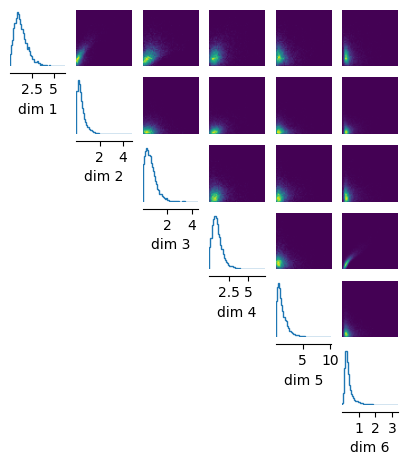

In [36]:
from sbi import analysis as analysis
x_o = torch.tensor(e_act)

posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, figsize=(5, 5)
)

Drawing 10000 posterior samples: 11492it [00:00, 14686.01it/s]                          


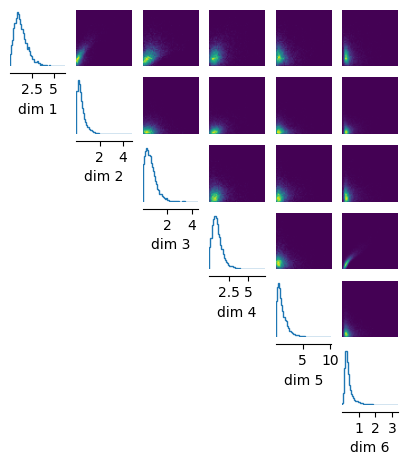

In [37]:
from sbi import analysis as analysis
x_o = torch.tensor(e_act)

e_posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, figsize=(5, 5)
)

Drawing 10000 posterior samples: 11372it [00:00, 21700.54it/s]                          


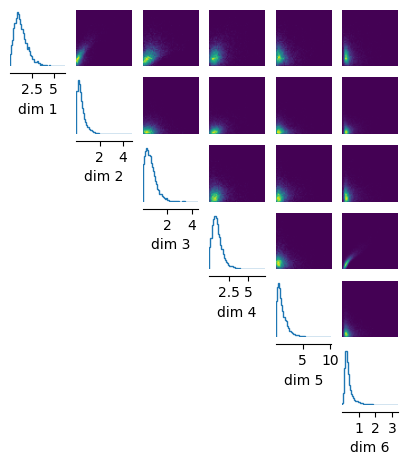

In [38]:
from sbi import analysis as analysis
x_o = torch.tensor(pv_act)

pv_posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, figsize=(5, 5)
)

In [39]:
pv_posterior_samples = posterior.sample((1,), x=x_o)


Drawing 1 posterior samples: 7324it [00:00, 28811.07it/s]         


In [40]:
simulator(pv_posterior_samples)

tensor([[0.0014, 0.0414, 0.0656, 0.0830, 0.0073, 0.0270]])

In [41]:
pv_act

array([0.20270902, 0.24957409, 0.2955943 , 0.4072691 , 0.5950653 ,
       0.73559046])

In [42]:
#e
e_posterior_samples.mode(dim=0)

torch.return_types.mode(
values=tensor([0.5701, 0.1110, 0.2020, 0.4153, 0.4962, 0.2138]),
indices=tensor([7368, 6399, 1005, 1701, 7607, 4396]))

### piv and som

In [23]:

#simulator

def simulator(wb):
    #define inputs
    A = np.concatenate((e_act[:,np.newaxis], -1* pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
    A = np.concatenate((A, np.zeros((A.shape[0],1))), axis = 1)
    A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)
    
    return power_law_nl(torch.tensor(A,dtype=torch.float32) @ wb)



In [24]:
# Check simulator, returns PyTorch simulator able to simulate batches.
simulator = process_simulator(simulator, prior, prior_returns_numpy)


In [25]:

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [26]:
inference = SNPE(prior=prior)

In [27]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:00<00:00, 3035.91it/s]

theta.shape torch.Size([1000, 6])
x.shape torch.Size([1000, 6])


In [28]:
inference = inference.append_simulations(theta, x)

In [29]:
density_estimator = inference.train()

 Neural network successfully converged after 287 epochs.

In [30]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


Drawing 10000 posterior samples: 10105it [00:01, 5187.92it/s]                          


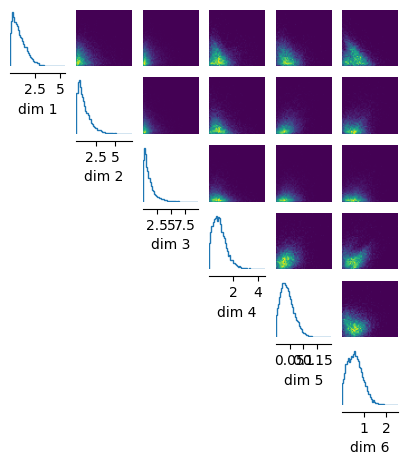

In [31]:
#vip from sbi import analysis as analysis
x_o = torch.tensor(vip_act)

vip_posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, figsize=(5, 5)
)

Drawing 10000 posterior samples: 11107it [00:00, 19594.65it/s]                          


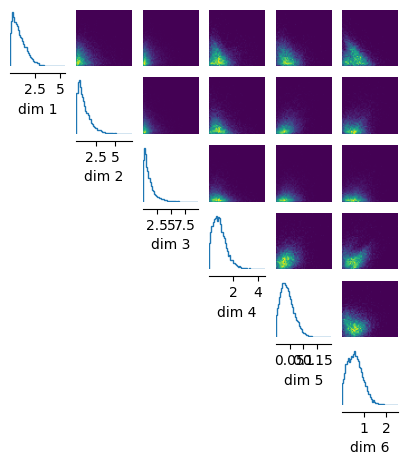

In [32]:
#som

x_o = torch.tensor(som_act)

som_posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, figsize=(5, 5)
)

In [33]:
simulator(som_posterior_samples).median(dim=0)

torch.return_types.median(
values=tensor([0.0059, 0.0044, 0.0149, 0.0478, 0.0571, 0.2530]),
indices=tensor([4004, 5506, 8815, 4192,  620, 8059]))

In [34]:
som_act

array([0.10236657, 0.12339172, 0.1086949 , 0.15047143, 0.26108373,
       0.55200543])